<a href="https://colab.research.google.com/github/yuwang1028/AI-Powered-Email-Agent-using-LangGraph/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q langgraph langchain_openai langchain_huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/1

In [15]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"  # Replace with your actual API key

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
# define the state
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

In [10]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint



# Initialize LLM
model = ChatOpenAI( model="gpt-4o",temperature=0)

class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

# Define nodes
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}

def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only reurn the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else :
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}

def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    return {
        "draft_response": response.content,
        "messages": new_messages
    }

def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")

    return {}

# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email) # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email) # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam) #same logic
email_graph.add_node("drafting_response", drafting_response) #same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne) # same logic


In [11]:
## Step 3: Define Our Routing Logic
# Add edges

email_graph.add_edge(START, "read_email") # After starting we go to the "read_email" node
email_graph.add_edge("read_email", "classify_email") # After reading the email we classify it
# add conditional edges
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "drafting_response"
    }
)

# add final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)

## Step 4: Create the StateGraph and Define Edges

In [12]:
# Compile the graph
compiled_graph = email_graph.compile()



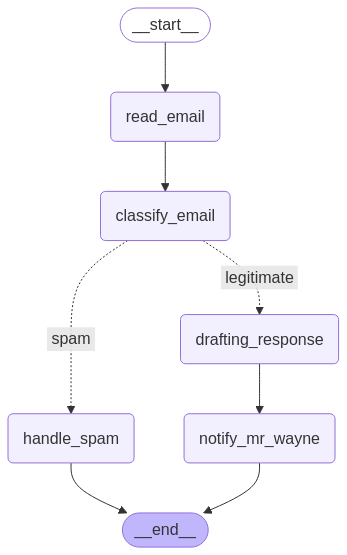

In [13]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [16]:
 # Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Mr. Joker,

Thank you for reaching out with your concerns. Mr. Wayne appreciates your interest and would like to assure you that any misunderstandings can be addressed in a calm and rational manner. We encourage open dialogue and are confident that any issues can be resolved amicably.

Please feel free to share any further details you might have, and we will do our best to address them promptly.

Kind regards,

Alfred Pennyworth  
On behalf of Bruce Wayne


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.
